# Neural & Behavioral Modeling - Week 10 (Exercises)
by 李采蓉 b08207042@ntu.edu.tw

In [2]:
# Upgrade PyTorch if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

/bin/bash: conda: command not found


In [3]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [4]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.12.1+cu113
No GPU


## 1 Tuning the performance of a neural net (8 points)

### 1.1 Problem
In the section 4.1 of model_10_examples.ipynb, the neural network implemented in NumPy with two hidden layers could reach 90% classification accuracy on the MNIST training data only within 3 learning epochs:

<pre>
model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                          weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)
</pre>

However, in the section 4.2, a similar network implemented in PyTorch did not reached 90% clasification accuracy model on the MNIST training data: 

<pre>
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    #t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    #t.nn.Linear(H, H),
    #t.nn.BatchNorm1d(H),
    #ct.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)
</pre>

Your goal is to do whatever you can to help the PyTorch net reach 90% classification accuracy on the MNIST training data within 50 or less epochs.

### 1.2 Tips

First try to eliminate the differences between the NumPy net and the PyTorch net:

(1) The PyTorch version did not use 50% Dropout.

(2) The PyTorch used Adam with a learning rate of 1e-4 as an optimizer instead of SGD with a learning rate of 1e-2.

(3) The PyTroch version did not use shuffled batch (100 samples) in each training epoch.


(4)If removal of the above differences does not help, look for other differences or do whatever you can to accelerate learning of the PyTorch net.

<b>(5) Do not waste your time on checking out training results after 50 epochs! They have nothing to do with your goal here.</b>

### 1.3 Your codes and discussions

#### 1.3.1 The MNIST dataset

In [5]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7f76c6971910>)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\>'
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\?'
  after removing the cwd from sys.path.


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


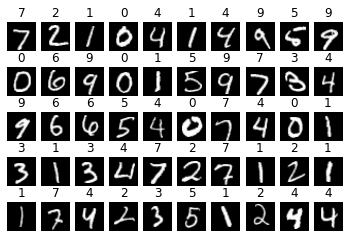

In [6]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

#### 1.3.2 Your systematic explorations

In [7]:
# Here is the PyTorch net:

D_in,H,D_out=784,1024,10

# Training the network:
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    # t.nn.Dropout(p=0.8),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    # t.nn.Dropout(p=0.8),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)

loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = t.optim.AdamW(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()
    
for i in range(51):
    # Forward pass:
    Y_pred = model(X_train)

    loss = loss_fn(Y_pred, Y_train)
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass:
    loss.backward()

    # Update the weights using gradient descent:
    optimizer.step()
    
    # Check training accuracy:
    if i % 10 == 0:
        Y_pred = model(X_train) # Y_pred.shape=[50000,10]
        Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
        print('epoch ',i,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  0 : 0.77224
epoch  10 : 0.92582
epoch  20 : 0.94882
epoch  30 : 0.96076
epoch  40 : 0.9689
epoch  50 : 0.97426


Accuracy on all testing samples: 0.9652
Accuracy on the first 50 testing samples: 0.94
Correct answers:
 [[7 2 1 0 4 1 4 9 5 9]
 [0 6 9 0 1 5 9 7 3 4]
 [9 6 6 5 4 0 7 4 0 1]
 [3 1 3 4 7 2 7 1 2 1]
 [1 7 4 2 3 5 1 2 4 4]]


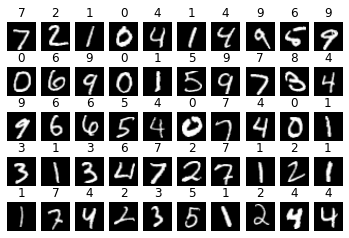

In [9]:
# Testing the network:
Y_pred = model(X_test) # Y_pred.shape=[50000,10]
Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
test_acc=(Y_pred==Y_test).sum().item()/Y_test.shape[0]
print('Accuracy on all testing samples:',test_acc)

# Visualize results of the first 50 testing samples:
Y_pred = model(X_test[0:50,]) # Y_pred.shape=[50000,10]
Y_pred = t.max(Y_pred[0:50],1)[1] # Y_pred.shape=[50000]
test_acc=(Y_pred==Y_test[0:50]).sum().item()/50
print('Accuracy on the first 50 testing samples:',test_acc)
print('Correct answers:\n',y_test[0:50].reshape([5,10]))

for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(Y_pred[i].item()));
    axis('off')

#### 1.3.3 Discussion
1) dropout適用於"參數多、樣本少"的情況下，原理是根據設定的機率(ex. 0.5)拋棄一層當中的一些node以防overfitting的情形產生(簡單來說就是選取的特徵太多導致訓練出的模型只適用於一小部分的樣本，無法推及到
更多不一樣的樣本)。然而在這題中並不適用dropout，因此剃除。
<br>
延伸閱讀：[深度学习中Dropout原理解析](https://zhuanlan.zhihu.com/p/38200980)

2) 選擇AdamW是根據經驗法則(?)，將lr調大則是因為1e-4太小，導致無法在有限的epoch中趨近鄰近的極小值，調大一點有助於走快一點，但風險是走到最小值附近因為步伐太大無法掉進洞裡(區域極小值的凹陷地帶)，只能在附近擺盪，這時候optimizer的選擇就極為重要，適當的算法和合適的momentum大小可以幫助模型逐漸降低lr大小，使的趨近區域極小值時能夠適時掉下去。<br>
延伸閱讀：[【Day 22】 Google ML - Lesson 8 - 學習速率 (learning rate) 介紹, 透過「learning rate」調整ML模型訓練的學習速度](https://ithelp.ithome.com.tw/articles/10219458)

3) 三層從初始結果上看起來神經元太少了，所以修改策略以又短又寬以達到傳統上的超深模型差不多的效果。

最後將testing丟進來檢驗，確認沒有overfitting(training和testing的accuracy會差很多的狀況)的問題。